In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from itertools import combinations

In [2]:
def clean(df):
    """
    - Removes unnecessary metadata at top of csv
    - Only selects columns we care about
    """
    clean = pd.DataFrame(data=df.loc[6:].values, columns=df.loc[5].values)[['Year', 'Yoshino peak bloom date']]
    clean = clean.rename(columns={'Yoshino peak bloom date':'Peak'})
    clean['Peak'] = clean['Peak'].map(int)
    return clean

In [3]:
# historical times for the peak cherry blossoms
# (when 70%) of blossoms have flowered
# you can find the data I used here: https://www.epa.gov/climate-indicators/cherry-blossoms
# click "download" under fig 1
df = clean(pd.read_csv('cherry-blossoms-dc.csv'))

# the data

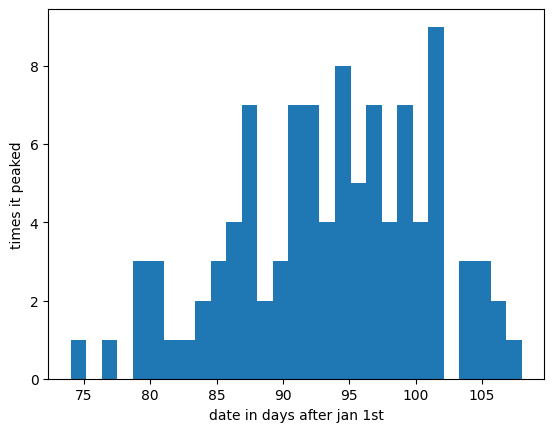

In [4]:
df['Peak'].hist(bins=len(df['Peak'].unique()))
plt.ylabel("times it peaked")
plt.xlabel("date in days after jan 1st")
plt.grid()
plt.show()

# Test what distribution it is
I went looking for any information on how weather patterns usually are distributed in Spring. [This paper](https://journals.ametsoc.org/view/journals/mwre/87/4/1520-0493_1959_087_0136_tdofaf_2_0_co_2.xml?tab_body=pdf) on the distribution of freeze days seemed to find that using a normal distribution was fine, but then they added a dichotomous distribution of freeze and freezeless years. Maybe there's something similar going on with blossoms, idk. Here, I try just a few distributions (3) to avoid p-hacking issues.

First I'll just see if this fits a normal distribution and after that I'll look for a distribution that is more shifted to match the above

In [5]:
# fit a normal distribution
model = stats.norm.fit(df['Peak'])

In [6]:
# perform a Kolmogorov–Smirnov test to check if it's a valid distribution matches.
stats.kstest(df['Peak'], "norm", model)

KstestResult(statistic=0.08042613304725899, pvalue=0.4989939351781164)

KS test's null hypothesis is that the distributions are identical. So here we do not reject the null hypothesis. 

From here on I will use this fitted normal distribution instead of the raw PDF measured from the data, since it will give us better granularity.

In [7]:
# get the pdf
x = np.linspace(70, 120, 1000)
pdf = stats.norm.pdf(x, *model)

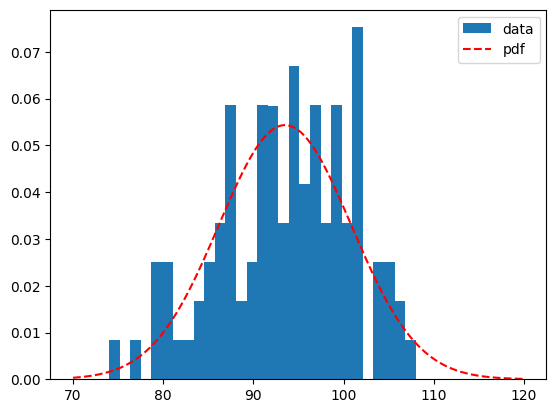

In [8]:
# plot the pdf and the histogram with fewer bins
plt.hist(df['Peak'], density=True, bins=len(df['Peak'].unique()), label='data')
plt.plot(x, pdf, '--r', label='pdf')
plt.legend()
plt.show()

# find best dates to book airbnbs

In [9]:
def compute_prob(dates, model):
    """Prob(peak happening something during dates)"""
    return sum(stats.norm.pdf(dates, *model))

In [10]:
def is_continuous(dates):
    """return whether dates are all in a row without gaps"""
    return all(a+1==b for a, b in zip(dates, dates[1:]))

In [11]:
def has_no_overlap(schedule):
    """returns whether schedule avoids overlapping days"""
    schedule = np.array(schedule).flatten()
    return schedule.shape == np.unique(schedule).shape

In [12]:
def find_best_times(nr_trips, len_trip, avail, model):
    """We want to book nr_trips different airbnbs, all for len_trip days.
    What are the optimal days to book those airbnbs s.t. we can cancel all
    but one once we know when the blossom will happen.
    (optimal wrt being within threshold of peak)
    
    nr_trips : number of airbnbs to book
    len_trip : how many days each trip will be
    avail : all the days we want to search over (ex: weekends)
    model : fitted parameters to generate norm model from
    :returns: schedule, probability
    
    Note:
        I couldn't find good data on how long cherry blossoms last, but all
        sources basically said "very short". Therefore we'll optimize for
        Prob(seeing peak day) and hope that the winning schedule would also 
        optimze for Prob(seeing at least SOME blossoms).
    """
    # Look away kids... next couple lines are gonna be pretty ugly. 
    # But with only tens of datapoints i dont need to care...
    
    # find all the valid potential date ranges to book an airbnb
    all_bookings = [[avail[i+j] for j in range(len_trip)] for i in range(len(avail)-(len_trip-1))]
    valid_bookings = [booking for booking in all_bookings if is_continuous(booking)]
    
    # find all valid (non-overlapping) combinations of bookings
    all_schedules = list(combinations(valid_bookings, nr_trips))
    valid_schedules = [sched for sched in all_schedules if has_no_overlap(sched)]
    
    # compute probability of success for each combination 
    #   (i.e. having an airbnb booked on the peak day)
    probs = []
    for sched in valid_schedules:
        sched = np.array(sched).flatten()
        probs.append(compute_prob(sched, model))
    best_idx = probs.index(max(probs))
    
    return valid_schedules[best_idx], probs[best_idx]

### consider only the weekends (saturday and sunday)

In [13]:
# here are the integers for all the weekends between march 11th and april 30th
# find more here: https://asd.gsfc.nasa.gov/Craig.Markwardt/doy2023.html
days_to_consider = [70, 71, 77, 78, 84, 85, 91, 92, 98, 99, 105, 106, 112, 113, 119, 120]
len_trip = 2  # im counting friday as a travel day. we might arrive in the dark...
nr_trips = 2  # let's not overcommit ourselves

In [14]:
find_best_times(nr_trips, len_trip, days_to_consider, model)

(([91, 92], [98, 99]), 0.19061681460784935)

### consider friday as well

In [15]:
days_to_consider = [69, 70, 71, 76, 77, 78, 83, 84, 85, 90, 91, 92, 97, 98, 99, 104, 105, 106, 111, 112, 113, 118, 119, 120]

In [16]:
find_best_times(2, 3, days_to_consider, model)

(([90, 91, 92], [97, 98, 99]), 0.2876238404228109)

### book 3 airbnbs

In [17]:
days_to_consider = [69, 70, 71, 76, 77, 78, 83, 84, 85, 90, 91, 92, 97, 98, 99, 104, 105, 106, 111, 112, 113, 118, 119, 120]

In [18]:
find_best_times(3, 3, days_to_consider, model)

(([83, 84, 85], [90, 91, 92], [97, 98, 99]), 0.3583673697091034)